<a href="https://colab.research.google.com/github/upascal/Historical-Computational-Social-Science/blob/main/AI_and_Cultural_Repositories_GPT3_5_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI and Cultural Repositories - GPT3.5 API - UCLA Summer Lab

### Main Project Overview:
 https://colab.research.google.com/drive/1I37K1qcbbDvoaw7CnQqCFmNK-ehBuL-O?usp=sharing

### Notebook Purpose:
Test ablity of GPT3.5 to help with question clustering



## Set up Notebook Environment


In [1]:
!pip install --upgrade openai
!pip install tiktoken
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.7 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [2]:
# import libraries
import pandas as pd
import glob
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

### Generate and Set Open AI Access Token


* Login to openai.com
* Navigate to settings.
* Set up billing
* Generate an API Key
* Copy the API Key
* In Google Colab: Click the "Key" icon on the left.
* Create colab notebook access token named `OPEN_AI_KEY`
* Copy and Paste the Access Token from Open AI under `Value`.
* Make sure `Notebook Access` is turned `On`.

This process allows you to acces models from Open AI

In [3]:
#@title Authenticate Notebook's Access

# Import Colab Secrets userdata module
from google.colab import userdata
import os

#Set the environment variable to the access token
os.environ["OPEN_AI_KEY"] = userdata.get('OPEN_AI_KEY')


In [4]:
#@title Setup of Open AI API
from openai import OpenAI

client = OpenAI(api_key=os.environ.get("OPEN_AI_KEY"))

# Define Text Processing Functions
def prompt_gpt(prompt, model = "gpt-3.5-turbo", max_tokens = 250, system="Your role is to parse data factually without generating hallucinations or fabrications"):
    '''
    Wraper for gpt api, so GPT can be queried with one function.
    Args:
    prompt: The query sent to the model API
    model: the version of gpt to be queried.
    - model default: "gpt-3.5-turbo"
    max_new_tokens: number of generated tokens
    system: The system level prompt that defines the models role
    - system default: "Your role is to parse data factually without generating hallucinations or fabrications"
    Returns: text response
    '''
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": prompt}
        ],
        temperature=0.9,
        max_tokens=max_tokens,
        top_p=0.1,
        frequency_penalty=0.2,
        presence_penalty=0.0,
    )
    return response.choices[0].message.content




In [5]:
#@title Test Open AI API

prompt_gpt("hi")

'Hello! How can I assist you today?'

## Data Importation

Use data with permisive privacy/use agreements

Fortunoff Holocaust Testimonies 2020:
https://drive.google.com/drive/folders/1Ej0lsqrybxFfZu-8bgTeKyE8DmTOJV3x

In [6]:
#@title Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


### Add the Shared Folder to Your Google Drive
* Navigate to the "Shared with Me" Section in Google Drive
* Find the `Holocaust and Genocide Studies Digital Research Lab` folder in the "Shared with me" area.
* Right-click the folder and choose "Add shortcut to Drive."
* Choose the `MyDrive` folder in your Drive to save the shortcut.

This will make the folder accessible through your Google Drive interface, allowing you to point to it from Google Colab.

# Extract Questions form Data

In [7]:
#@title Import Necessary Data from Google Drive

#Set Folder Path
folder_path = '/content/drive/MyDrive/Holocaust and Genocide Studies Digital Research Lab/Data Cleaned - Ready to Use/Fortunoff Holocaust Testimonies 2020'
# combine all csv files into a single dataframe
all_files = glob.glob(folder_path + "/*.xlsx")

li = []

for filename in all_files:
    # read in each excel file
    df = pd.read_excel(filename, index_col=None, header=0)
    # add sent_num to each csv file
    df.insert(1, 'sent_num', list(range(1, len(df)+1)))
    li.append(df)

In [8]:
#@title Combine Data into one Data Frame

#aggregate results into a single dataframe
fortunoff_df = pd.concat(li, axis=0, ignore_index=True)

# reorder columns
fortunoff_df = fortunoff_df.sort_values(by=['file_num','file_part','time'])

# create an index column as reference (used later for answer extraction)
fortunoff_df['manual_index'] = list(range(1, len(fortunoff_df)+1))
fortunoff_df = fortunoff_df.reset_index(drop=True)

In [9]:
fortunoff_df

,file_num,sent_num,file_part,time,speaker,text,is_interviewee,manual_index
0,1,1,1,00:00:00.46,NaN,NaN,2,1
1,1,2,1,00:00:03.30,INTERVIEWER 1,We're going to go back into the past. Where ar...,0,2
2,1,3,1,00:00:09.99,SUBJECT,"Well, uh, I grew up in Czechoslovakia. I went ...",1,3
3,1,4,1,00:00:17.88,INTERVIEWER 1,Where?,0,4
4,1,5,1,00:00:18.93,SUBJECT,"In Prague. In the city, in the center of the h...",1,5
...,...,...,...,...,...,...,...,...
73826,200,396,3,00:43:24.39,VICTOR EHRLICH,"Of course, all this was dealt a-- I think-- a ...",1,73827
73827,200,397,3,00:44:02.82,VICTOR EHRLICH,"The fact is that, uh, you know, you need, for ...",1,73828
73828,200,398,3,00:44:41.42,INTERVIEWER,"I've kept you longer than I should, I know. Uh...",0,73829
73829,200,399,3,00:44:55.46,CREW,"OK, that's it.",2,73830


In [10]:
# export transcript of all interviewer and interviewee lines
#fortunoff_df.to_csv('full_Fortunoff_transcripts.csv')

# Extract Interviewer Questions

In [11]:
# for BERT clustering purposes, only keep rows with interview questions
# For Fortunoff, 0.0 in column "is_interviewee" indicates an interviewer
fortunoff_qs = fortunoff_df.loc[fortunoff_df['is_interviewee'] == 0.0]

len(fortunoff_qs)

22654

In [14]:
# divide words column with multi-sentences into a list
# using sentence tokenizer
fortunoff_qs.text = fortunoff_qs.text.apply(lambda x: sent_tokenize(str(x)))

<ipython-input-14-603816d2947a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fortunoff_qs.text = fortunoff_qs.text.apply(lambda x: sent_tokenize(str(x)))


In [15]:
# Now, keep only the questions/interrogative statements spoken by the interviewer.
# we remove any sentence that doesn't include any of the key words/symbols
# included in the list below.

keys = ['?', 'tell', 'describe', 'share', 'sing', 'message', 'photograph', 'ask', 'did you', 'were you']

id_list=[]
sent_num_list=[]
time_list=[]
manual_index_list = []
texts_list=[]
is_interviewee_list = []

for i in range(len(fortunoff_qs)):
    for j in fortunoff_qs.text.iloc[i]: # j is a sentence
        if any(ele in j for ele in keys):
            id_list.append(fortunoff_qs.file_num.iloc[i])
            sent_num_list.append(fortunoff_qs.sent_num.iloc[i])
            time_list.append(fortunoff_qs.time.iloc[i])
            manual_index_list.append(fortunoff_qs.manual_index.iloc[i])
            is_interviewee_list.append(fortunoff_qs.is_interviewee.iloc[i])
            texts_list.append(j)
fortunoff_intqs = pd.DataFrame()
fortunoff_intqs["file_num"]=id_list
fortunoff_intqs["sent_num"]=sent_num_list
fortunoff_intqs["text"]=texts_list
fortunoff_intqs["time"]=time_list
fortunoff_intqs["manual_index"]=manual_index_list
fortunoff_intqs["is_interviewee"]=is_interviewee_list

In [16]:
fortunoff_intqs

,file_num,sent_num,text,time,manual_index,is_interviewee
0,1,2,Where are you from?,00:00:03.30,2,0
1,1,4,Where?,00:00:17.88,4,0
2,1,6,Do you remember the old city?,00:00:23.53,6,0
3,1,8,"As a Jewish person, did you feel any differenc...",00:00:42.40,8,0
4,1,10,Would you mind repeating my question so that i...,00:00:53.12,10,0
...,...,...,...,...,...,...
16581,200,363,Where does it leave you?,00:28:35.93,73794,0
16582,200,365,Where does all this leave you?,00:29:00.92,73796,0
16583,200,379,Her mother?,00:36:06.82,73810,0
16584,200,383,Do you know how the others died?,00:37:38.91,73814,0


# Extract Answers and Answer length

In [17]:
# copy the dataframe with all testimony lines
full_df = fortunoff_df.copy()

# copy the dataframe with questions from the interviewer
qs_df = fortunoff_intqs.copy()

In [18]:
# Extracting answers:
# following each question, find each line not spoken by the interviewer
# until the next time the interviewer speaks

ans_list = []
for index in qs_df.manual_index:
    ans_text = ''
    curr_index = index
    while full_df.is_interviewee[curr_index] != 1:
        curr_index += 1
    while full_df.is_interviewee[curr_index] == 1:
        if type(full_df.text[curr_index]) == int or type(full_df.text[curr_index]) == float:
            ans_text += str(full_df.text[curr_index]) + ' '
        else:
            ans_text += full_df.text[curr_index] + ' '
        curr_index += 1
    ans_list.append(ans_text)

# add answers to data frame
qs_df['answer'] = ans_list

In [19]:
# get question and answer word count and save as a column in the dataframe
qword_count = []
answord_count = []
for i in range(len(qs_df)):
    qword_count.append(len(str(qs_df['text'][i]).split()))
    answord_count.append(len(str(qs_df['answer'][i]).split()))

qs_df['question_length'] = qword_count
qs_df['answer_length'] = answord_count

In [20]:
qs_df

,file_num,sent_num,text,time,manual_index,is_interviewee,answer,question_length,answer_length
0,1,2,Where are you from?,00:00:03.30,2,0,"Well, uh, I grew up in Czechoslovakia. I went ...",4,18
1,1,4,Where?,00:00:17.88,4,0,"In Prague. In the city, in the center of the h...",1,18
2,1,6,Do you remember the old city?,00:00:23.53,6,0,"Oh, very well. I very vividly remember the wal...",6,48
3,1,8,"As a Jewish person, did you feel any differenc...",00:00:42.40,8,0,"Before the war, not really, no.",11,6
4,1,10,Would you mind repeating my question so that i...,00:00:53.12,10,0,"Yeah. Well, I'm not aware of there being much ...",12,58
...,...,...,...,...,...,...,...,...,...
16581,200,363,Where does it leave you?,00:28:35.93,73794,0,What?,5,1
16582,200,365,Where does all this leave you?,00:29:00.92,73796,0,"Now, of course, all of this-- this is part of ...",6,772
16583,200,379,Her mother?,00:36:06.82,73810,0,"Oh, she-- oh, Iza's mother died when she was a...",2,190
16584,200,383,Do you know how the others died?,00:37:38.91,73814,0,"They were, yes. I think they were taken to Aus...",7,814


## Clustering

The next step, we represent each sentence as an embedding so we can apply a clustering algorithm to tease out the main topics/themes in the historical data.


In [21]:
#@title Intialize Dataframe For Text Embeddings
import pandas as pd
from openai import OpenAI
client = OpenAI(api_key=os.environ.get("OPEN_AI_KEY"))

# Define Get Embedding Function
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = text, model=model).data[0].embedding

# Drop the NaN values in the 'text' column
df = qs_df.dropna()

# Save the full DataFrame
df_full = df.copy()

# Define the testing flag
testing = True

# If testing, use a sample of the DataFrame
if testing:
    # Select a random subset of 100 rows for testing
    df = df_full.sample(n=1000, random_state=42)  # Use random_state for reproducibility
    EMBEDDING_FILE_PATH = 'output/subset_combined_Fortunoff_Holocaust_Testimonies_2020_with_embeddings.csv'
else:
    df = df_full
    EMBEDDING_FILE_PATH='output/combined_Fortunoff_Holocaust_Testimonies_2020_with_embeddings.csv'

In [23]:
#@title Generate Text Embeddings

# Set embedding Model
embedding_model = "text-embedding-3-small"

# Encode all text in the subset DataFrame
df["embedding"] = df.text.apply(lambda x: get_embedding(x, model=embedding_model))

# Check if output dir exists
output_dir = os.path.dirname(EMBEDDING_FILE_PATH)
os.makedirs(output_dir, exist_ok=True)

In [24]:
# save the DataFrame to a file
#Save File Path
df.to_csv(EMBEDDING_FILE_PATH, index=False)

In [ ]:
# @title K-means Clustering
# Note: This could talke a while for large max_k

import pandas as pd
import numpy as np

# Import the Embedding File
df = pd.read_csv(EMBEDDING_FILE_PATH)

# Convert the embeddings back to an np array
df['embedding'] = df['embedding'].apply(eval)
embeddings = np.stack(df['embedding'].values)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Determine the number of clusters
def determine_k(embeddings, max_k):
    sum_of_squared_distances = []
    silhouette_scores = []
    K = range(2, max_k)  # Example: testing a range of cluster counts from 2 to 10

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans = kmeans.fit(embeddings)
        sum_of_squared_distances.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

    # Plotting the elbow curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method For Optimal k')

    # Plotting the silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis For Optimal k')
    plt.show()

# Run the function
determine_k(embeddings, 100) #Pick a max_k > what you assume k will be.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


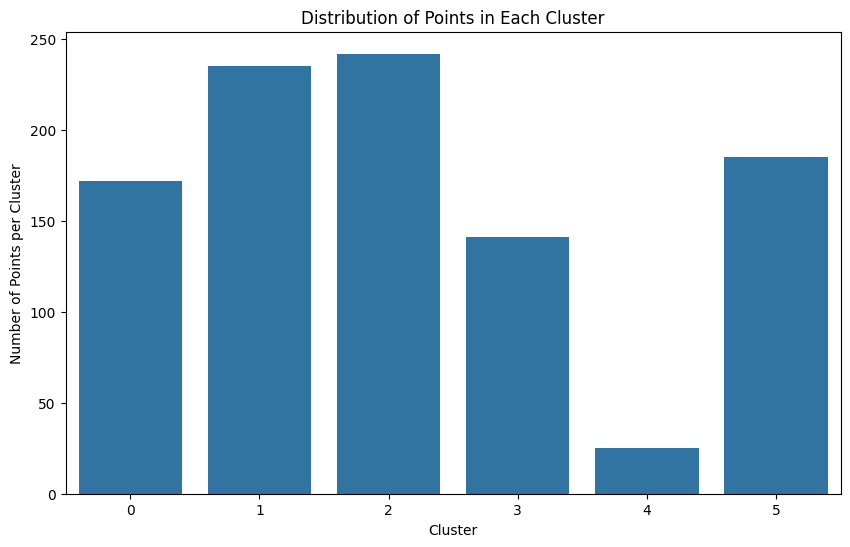

In [ ]:
#@title Inspect Clusters
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Configure the number of clusters
n_clusters = 6  # Example number of clusters, adjust based on your analysis

# Initialize KMeans and fit it to your embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['KMeans_cluster'] = kmeans.fit_predict(embeddings)

# Review the distribution of clusters
cluster_counts = df['KMeans_cluster'].value_counts().sort_index()

# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Points per Cluster')
plt.title('Distribution of Points in Each Cluster')
plt.show()

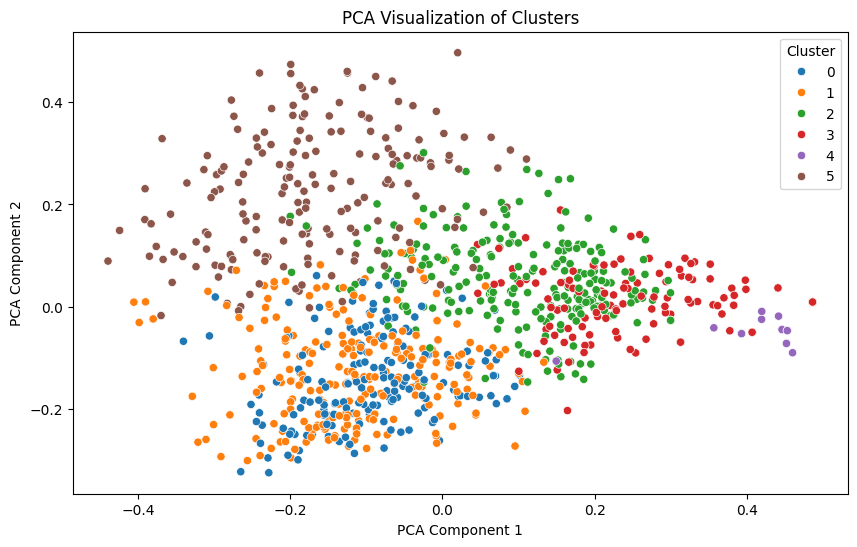

Cluster Centroids:
[[ 0.00062459 -0.0163047  -0.03367783 ... -0.01133451 -0.00650907
  -0.00035199]
 [ 0.01290432 -0.0057651  -0.01707632 ... -0.0183085  -0.00991373
  -0.00655142]
 [ 0.00409915  0.0033092  -0.00283505 ... -0.01056428 -0.00910566
   0.00635482]
 [ 0.01633485  0.00855143 -0.02196476 ... -0.01254488  0.00071838
   0.00407686]
 [ 0.04112378  0.0010577  -0.01314674 ... -0.00644009 -0.01127895
   0.01375135]
 [-0.01552485  0.01385905 -0.01726493 ... -0.00877239  0.00082846
  -0.01180142]]


In [ ]:
# Visualize clusters using PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], hue=df['KMeans_cluster'], palette='tab10', legend='full')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Clusters')
plt.legend(title='Cluster')
plt.show()

# Inspect cluster centroids
centroids = kmeans.cluster_centers_
print("Cluster Centroids:")
print(centroids)

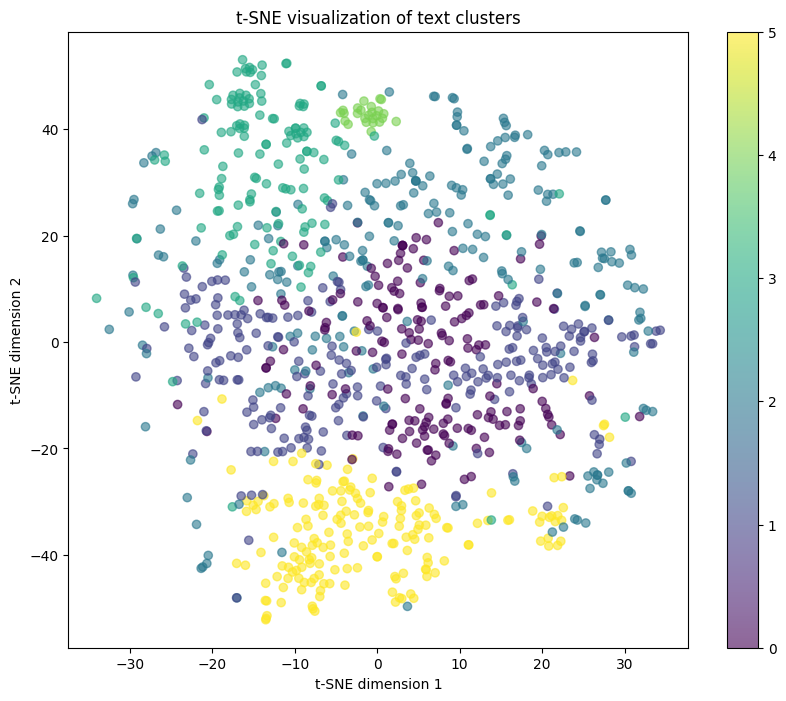

In [ ]:
#@title Visualize Clusters with TSNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the results with cluster labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['KMeans_cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of text clusters')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

In [ ]:
# save KMeans Clustered data
df.to_csv('/content/drive/MyDrive/Holocaust and Genocide Studies Digital Research Lab/GPT_output/KMeans_clustered_Fortunoff_Holocaust_Testimonies_2020.csv', index=False)

# Clustering with HDBSCAN

In [ ]:
#@title Clustering with HDBSCAN
import hdbscan
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Import the Embedding File
df = pd.read_csv('/content/drive/MyDrive/Holocaust and Genocide Studies Digital Research Lab/GPT_output/KMeans_clustered_Fortunoff_Holocaust_Testimonies_2020.csv')

# Convert the embeddings back to an np array
df['embedding'] = df['embedding'].apply(eval)
embeddings = np.stack(df['embedding'].values)

hdbscan_min_samples=1
hdbscan_min_cluster_size=5
hdbscan_max_cluster_size=500
hdbscan_cluster_selection_method="leaf"# can be "leaf" or "eom"
prediction_data=False

# Initialize and fit HDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=hdbscan_min_samples,
                  min_cluster_size=hdbscan_min_cluster_size,
                  max_cluster_size=hdbscan_max_cluster_size,
                  cluster_selection_method=hdbscan_cluster_selection_method,
                  prediction_data=prediction_data)

labels = clusterer.fit(embeddings).labels_

# Store the cluster labels in the DataFrame
df['HDBSCAN_cluster'] = labels

# Summary of clustering
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

Estimated number of clusters: 30
Estimated number of noise points: 708


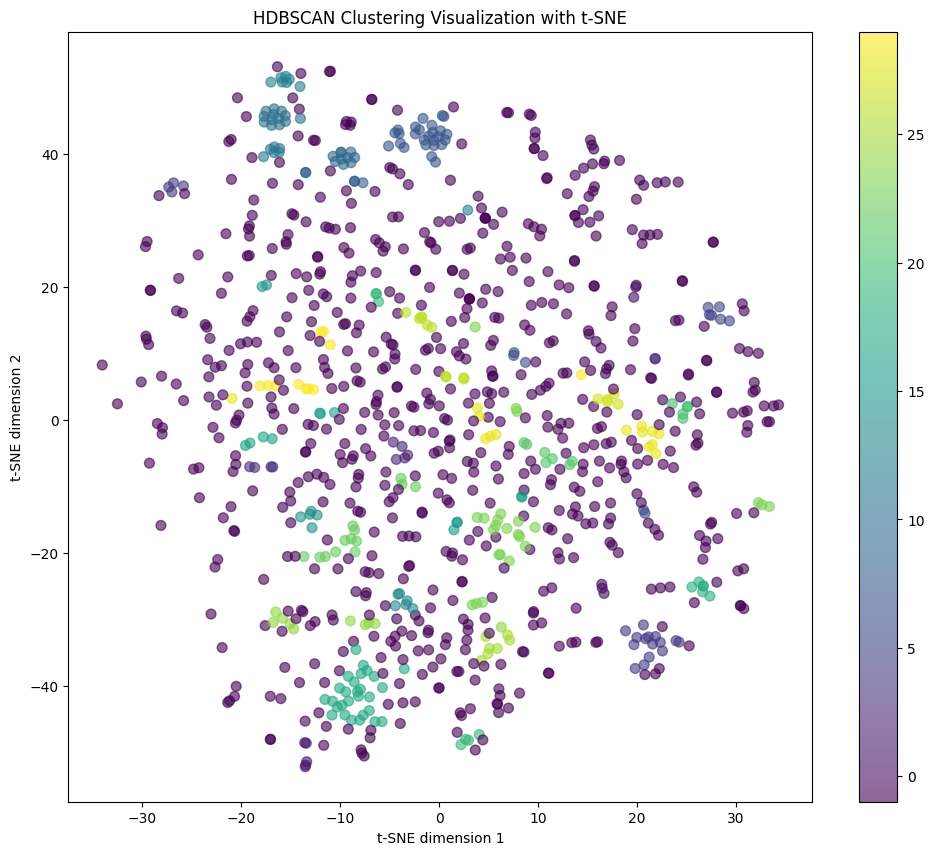

In [ ]:
#@title Visualize HDBSCAN Clusters

# Apply t-SNE to reduce dimensionality for visualization (2D)
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['HDBSCAN_cluster'], cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter)
plt.title('HDBSCAN Clustering Visualization with t-SNE')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

In [ ]:
df.head()

,file_num,file_part,time,speaker,text,is_interviewee,embedding,KMeans_cluster,HDBSCAN_cluster
0,107,1,00:14:51.74,INTERVIEWER 2,Did you notice-- did you talk to non-Jewish pe...,0,"[0.012823580764234066, -0.0016121120424941182,...",5,17
1,34,2,00:11:52.99,INTERVIEWER 2,But you were there.,0,"[0.0016715270467102528, 0.028290212154388428, ...",1,28
2,186,1,00:01:24.06,INTERVIEWER,Can you each tell me about your family's-- the...,0,"[0.05409349128603935, -0.00022005608479958028,...",1,28
3,193,2,00:05:57.03,INTERVIEWER 2,So they didn't--,0,"[0.05808979272842407, 0.03197719156742096, -0....",2,16
4,173,1,00:02:58.30,INTERVIEWER 1,Or who'll catch you?,0,"[0.02630528248846531, -0.013545790687203407, -...",2,-1


In [ ]:
# save HDBSCAN Clustered data
df.to_csv('/content/drive/MyDrive/Holocaust and Genocide Studies Digital Research Lab/GPT_output/HDBSCAN_clustered_Fortunoff_Holocaust_Testimonies_2020.csv', index=False)

In [ ]:
#@title Reduce Dimensionality
# We can reduce the dimensonality of embeddings
# This might help mitigate noise

import numpy as np

def normalize_l2(x):
    x = np.array(x)
    if x.ndim == 1:
        norm = np.linalg.norm(x)
        if norm == 0:
            return x
        return x / norm
    else:
        norm = np.linalg.norm(x, 2, axis=1, keepdims=True)
        return np.where(norm == 0, x, x / norm)


def reduced_demension(embedding, target_dim):
    # Ensure embedding is a NumPy array
    embedding = np.array(embedding)
    # Shorten the embedding
    shortened_embedding = embedding[:target_dim]
    # Normalize the shortened embedding
    normalized_embedding = normalize_l2(shortened_embedding)
    return normalized_embedding

# Load  DataFrame
df = pd.read_csv('/content/drive/MyDrive/Holocaust and Genocide Studies Digital Research Lab/GPT_output/HDBSCAN_clustered_Fortunoff_Holocaust_Testimonies_2020.csv')

# Convert the embeddings back to an np array
df['embedding'] = df['embedding'].apply(eval)
embeddings = np.stack(df['embedding'].values)

# Reduce the demension of embeedings to target number of dimensions
df['embedding_normalized'] = df['embedding'].apply(lambda x: reduced_demension(x, 50))

# Convert embeddings to numpy array
embedding_normalized = np.stack(df['embedding_normalized'].values)



Estimated number of clusters: 33
Estimated number of noise points: 697


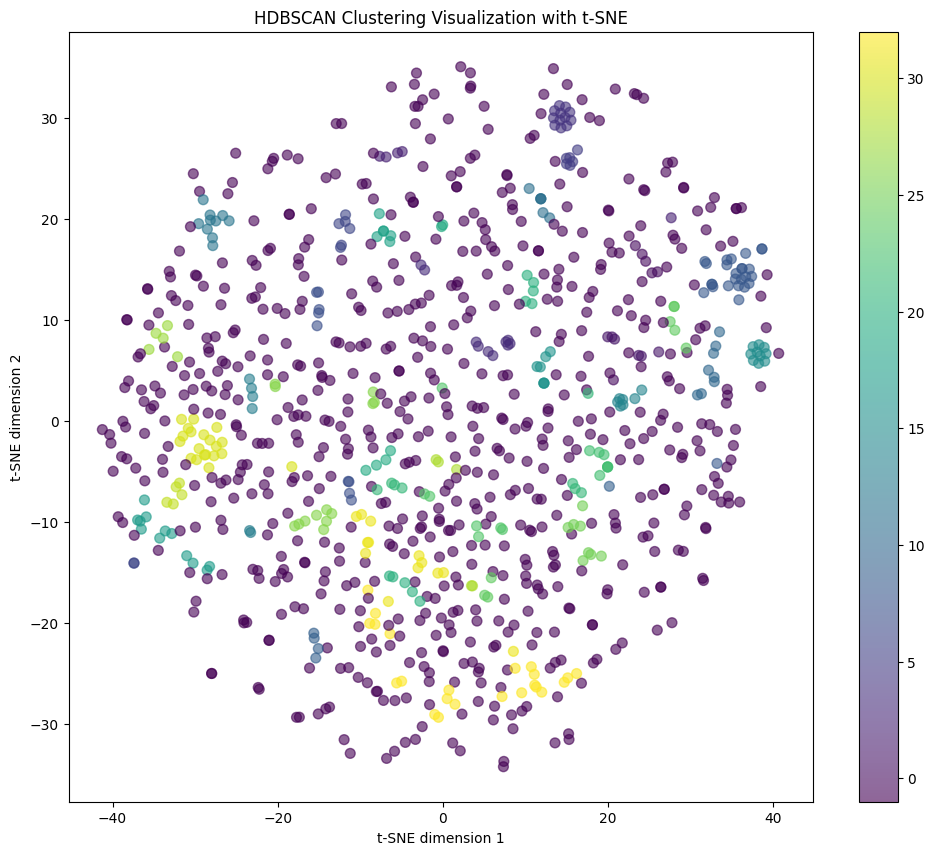

In [ ]:
import hdbscan
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run HDBSCAN with normalized embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, cluster_selection_method='leaf')
labels = clusterer.fit(embedding_normalized).labels_

df['HDBSCAN_norm_cluster'] = labels
# Summary of clustering
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Visualization with t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embedding_normalized)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['HDBSCAN_norm_cluster'], cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter)
plt.title('HDBSCAN Clustering Visualization with t-SNE')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()


In [ ]:
# save HDBSCAN Clustered data
df.to_csv('/content/drive/MyDrive/Holocaust and Genocide Studies Digital Research Lab/GPT_output/HDBSCAN_normalized_clustered_Fortunoff_Holocaust_Testimonies_2020.csv', index=False)

# Compare agreement between clustering methods

In [ ]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score

# Create a contingency table
contingency_table = pd.crosstab(df['KMeans_cluster'], df['HDBSCAN_cluster'])

# Display the table
print("Contingency Table between KMeans and HDBSCAN:\n", contingency_table)


Contingency Table between KMeans and HDBSCAN:
 HDBSCAN_cluster  -1    0    1    2    3    4    5    6    7    8   ...   20  \
KMeans_cluster                                                     ...        
0                131    2    0    0    0    0    0    5    0    0  ...    0   
1                169    1    0    4    5    1    0    0    0    0  ...    5   
2                199    3    0    1    1    6    6    0    0    0  ...    0   
3                 94    0    0    0    0    2    0    0    2    5  ...    0   
4                  1    0    0    0    0    0    0    0   24    0  ...    0   
5                114    0    5    0    0   10    0    0    0    0  ...    0   

HDBSCAN_cluster   21   22   23   24   25   26   27   28   29  
KMeans_cluster                                                
0                  2    1   18    0    0    5    0    2    0  
1                  5   11    0    1    0    0    4   11    8  
2                  0    1    3    1    0    5    1    1    3  
3    

In [ ]:
# Create a DataFrame for easier manipulation
cluster_combinations = pd.crosstab(df['KMeans_cluster'], df['HDBSCAN_cluster'])
cluster_combinations_norm = pd.crosstab(df['KMeans_cluster'], df['HDBSCAN_norm_cluster'])

print("KMeans vs HDBSCAN Co-occurrence:\n", cluster_combinations)
print("KMeans vs HDBSCAN_norm Co-occurrence:\n", cluster_combinations_norm)


KMeans vs HDBSCAN Co-occurrence:
 HDBSCAN_cluster  -1    0    1    2    3    4    5    6    7    8   ...   20  \
KMeans_cluster                                                     ...        
0                131    2    0    0    0    0    0    5    0    0  ...    0   
1                169    1    0    4    5    1    0    0    0    0  ...    5   
2                199    3    0    1    1    6    6    0    0    0  ...    0   
3                 94    0    0    0    0    2    0    0    2    5  ...    0   
4                  1    0    0    0    0    0    0    0   24    0  ...    0   
5                114    0    5    0    0   10    0    0    0    0  ...    0   

HDBSCAN_cluster   21   22   23   24   25   26   27   28   29  
KMeans_cluster                                                
0                  2    1   18    0    0    5    0    2    0  
1                  5   11    0    1    0    0    4   11    8  
2                  0    1    3    1    0    5    1    1    3  
3                 

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Calculate ARI between different methods
ari_kmeans_hdbscan = adjusted_rand_score(df['KMeans_cluster'], df['HDBSCAN_cluster'])
ari_kmeans_hdbscan_norm = adjusted_rand_score(df['KMeans_cluster'], df['HDBSCAN_norm_cluster'])
ari_hdbscan_hdbscan_norm = adjusted_rand_score(df['HDBSCAN_cluster'], df['HDBSCAN_norm_cluster'])

print(f"ARI between KMeans and HDBSCAN: {ari_kmeans_hdbscan:.4f}")
print(f"ARI between KMeans and HDBSCAN_norm: {ari_kmeans_hdbscan_norm:.4f}")
print(f"ARI between HDBSCAN and HDBSCAN_norm: {ari_hdbscan_hdbscan_norm:.4f}")


ARI between KMeans and HDBSCAN: 0.0388
ARI between KMeans and HDBSCAN_norm: 0.0440
ARI between HDBSCAN and HDBSCAN_norm: 0.3824


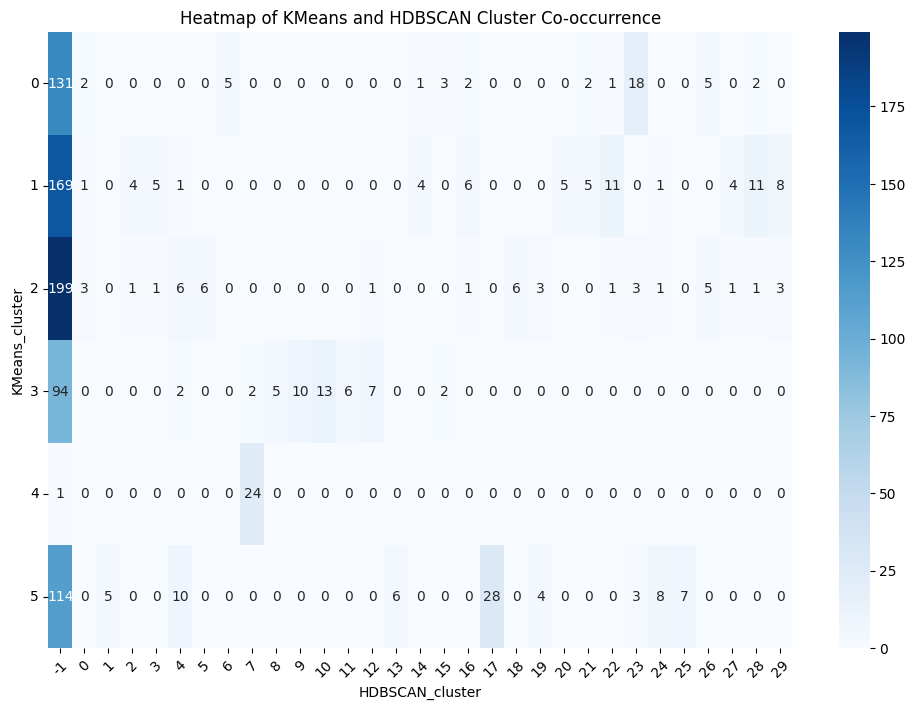

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap with formatted numbers
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(cluster_combinations, annot=True, fmt='d', cmap='Blues')

# Optionally adjust the annotation size
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title('Heatmap of KMeans and HDBSCAN Cluster Co-occurrence')
plt.show()


In [ ]:
import pandas as pd

CLUSTER_FILE_NAME = 'output/HDBSCAN_clustered_Fortunoff_Holocaust_Testimonies_2020'

# Save Clusteres
df.to_csv(CLUSTER_FILE_NAME, encoding='utf-8', index=False)

In [ ]:
#@title Inspect Clusters

# Load your DataFrame
df = pd.read_csv(CLUSTER_FILE_NAME)

# Assuming df is your DataFrame with a 'text' and 'cluster' column
clusters = df.groupby('cluster')

# Define the number of samples you want to display per cluster
samples_per_cluster = 5

for name, group in clusters:
    print(f"Cluster {name} examples:")
    print(group['text'].sample(n=samples_per_cluster, random_state=1))  # Change random_state for different samples
    print("\n")  # Print a newline for better readability



Cluster -1 examples:
53                                         One farmer--
2     I said, we have no right to judge. Because in ...
45         A gro-- a store, not grocery, um, dry goods.
94                                That's what happened.
61         I would like to ask you a personal question.
Name: text, dtype: object


Cluster 0 examples:
99    You remember?
52             Mhm.
50              Oh.
8           Really?
66    That's right.
Name: text, dtype: object


Cluster 1 examples:
7     I found a very nice young doctor's family who ...
86    And after Buchenwald, they sent us to another ...
10    I think the Soviets-- you know, in 1942, the s...
62    Now, a friend of mine who was the leader of ou...
76    But the reason why I took brain surgery becaus...
Name: text, dtype: object




In [ ]:
import pandas as pd
import os
import openai
import json

# Get Open ai key
client = OpenAI(api_key=os.environ.get("OPEN_AI_KEY"))

# Define a function for naming clusters
def generate_cluster_description(prompt):
    system_prompt = "You are a helpful and accurate analyst. If you dont know the answer say NaN."
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

In [ ]:
# Randomly select one cluster
random_cluster_id = df['cluster'].sample(n=1, random_state=42).iloc[0]

# Select all entries from this randomly chosen cluster
#test_cluster = df[df['cluster'] == random_cluster_id]
#clusters = test_cluster.groupby('cluster')

# Group by cluster
clusters = df.groupby('cluster')

#select random samples of each cluster
selected_examples = {name: group['text'].sample(n=2, random_state=42).tolist() for name, group in clusters}

# Generate prompts
prompts = {cluster_id: f"Here are random samples drawn from a clustering algorithm that clustered sentences holocaust testimonties. Please provide up to three tags or categories that encapsulate the type of question from the following randomly drawn samples: {examples}. Use the Folloing format: ['Tag 1', 'Tag 2', 'Tag 3']."
           for cluster_id, examples in selected_examples.items()}

# Generate tags for each cluster and save progress
cluster_tags = {}
for cluster_id, prompt in prompts.items():
    cluster_tags[cluster_id] = generate_cluster_description(prompt)
    # Save progress after each API call
    with open('cluster_tags_progress.json', 'w') as f:
        json.dump(cluster_tags, f)

print("Cluster Tags:", cluster_tags)

Cluster Tags: {-1: "['Uncertainty', 'Request for Specific Information', 'Memory Recall']", 0: 'NaN', 1: "['Witness account', 'Concentration camp conditions', 'Awareness of atrocities']"}


In [ ]:
import ast
import re

data = cluster_tags

compiled_list = []

# Regular expression to match items inside brackets
pattern = re.compile(r"'([^']+)'\s*(?:,|$)")

for list_str in data.values():
    matches = pattern.findall(list_str)
    compiled_list.extend(matches)

# Remove duplicates
unique_tags = list(set(compiled_list))

print(unique_tags)

['Concentration camp conditions', 'Uncertainty', 'Request for Specific Information', 'Witness account']


In [ ]:
#@title Evalutation

'''Code to evaluate/benchmark the models'''